# **<center>Notebook: Memory for Surprise-driven Exploration (Classic Control Ver.)</center>**





















**Reference:**
1. Burda, Y., Edwards, H., Storkey, A., & Klimov, O. (2018). Exploration by random network distillation. arXiv preprint arXiv:1810.12894.
2. Pathak, D., Agrawal, P., Efros, A. A., & Darrell, T. (2017, July). Curiosity-driven exploration by self-supervised prediction. In International conference on machine learning (pp. 2778-2787). PMLR.
3. Huang, S., Dossa, R. F. J., Ye, C., Braga, J., Chakraborty, D., Mehta, K., & AraÃšjo, J. G. (2022). Cleanrl: High-quality single-file implementations of deep reinforcement learning algorithms. Journal of Machine Learning Research, 23(274), 1-18.
4. Brockman, G., Cheung, V., Pettersson, L., Schneider, J., Schulman, J., Tang, J., & Zaremba, W. (2016). Openai gym. arXiv preprint arXiv:1606.01540.


In this notebook we present the implementation of method in the paper **"Exploration by random network distillation"**, which we refer to as RND intrinsic reward, and in the paper **"Curiosity-driven exploration by self-supervised prediction"**, which we refer to as ICM intrinsic reward.

## **1. Setting up the libraries** 

In [1]:
# Run these commands from the terminal to install related libraries and set up the working environment
# pip install gym # Install the gym library with RL environments
# pip install envpool
# pip install torch

In [2]:
import os, random, time
from collections import deque
from dataclasses import dataclass

import pandas as pd
# import gym
import gymnasium as gym
import numpy as np
import torch
import envpool

import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter
from gym.wrappers.normalize import RunningMeanStd
import matplotlib.pyplot as plt



## **2. CartPole Environment**

- In this notebook we will use the simple CartPole-v1 environment (https://www.gymlibrary.dev/environments/classic_control/cart_pole/) for demonstration. 🎮 
- The goal in this environment is to balance the pole on top of a cart by applying left or right action.
- The observation space is (4,), including cart position, cart velocity, pole angle and pole angular velocity. And, action space is Discrete(2) including action to move left or right. 🔄 You will get a +1 reward for each step the Pole is standing.
- This notebook can also be used for other classic control environments as well. 😊 All you need to do is change the env_id and the state and action space. 

<p align="center">
  <img src="https://www.gymlibrary.dev/_images/cart_pole.gif" width="300" height="200">
</p>


## **3. Simple PPO** 

**If you only want to run the surprise motivation, please run until section 3.2.2 to initialize the parameters and PPO.**
- In this section, we will test a simple PPO algorithm on the CartPole-v1 environment. 🕹️
- The implementation of PPO in this notebook is inspired by the implementation of PPO from CleanRL package. 📊
- The result of this algorithm will be presented at the end of the notebook. 📝

### **3.1 Parameters**

In [3]:
params = {'env_id': 'CartPole-v1',                              # env_id can be changed here
          'exp_name': "RND",
          'torch_deterministic': True,
          'cuda': True,
          'seed': 1,
          'num_envs': 8,                                        # number of multi-environments
          'num_steps': 128,                                     # number of steps running in each environments per rollout
          'num_minibatches': 4,                                 # number of minibatches
          'total_timesteps': 100000,                            # total training timesteps
          'learning_rate': 2.5e-4,                              # learning_rate
          'anneal_lr': True,                                    # reducing learning rate during learning
          'num_iterations_obs_norm_init': 50,
          'gamma': 0.99,
          'int_gamma': 0.99,
          'gae_lambda': 0.95,
          'int_coef': 1.0,
          'ext_coef': 2.0,
          'update_epochs': 4,
          'update_proportion': 0.25,
          'clip_coef': 0.2,
          'norm_adv': True,
          'clip_vloss': True,
          'ent_coef': 0.00,
          'vf_coef': 0.5,
          'max_grad_norm': 0.5,
          'target_kl': None}


state_space = 4                                                    # state space of env
action_space = 2                                                   # action space of env

device = torch.device("cuda" if torch.cuda.is_available() and params["cuda"] else "cpu")

# Set seed.
random.seed(params["seed"])                                                 
np.random.seed(params["seed"])
torch.manual_seed(params["seed"])
torch.backends.cudnn.deterministic = params["torch_deterministic"]


### **3.2 Models**

#### **3.2.1 Utils**

In [4]:
class RecordEpisodeStatistics(gym.Wrapper):
    def __init__(self, env, deque_size=100):
        super().__init__(env)
        self.num_envs = getattr(env, "num_envs", 1)
        self.episode_returns = None
        self.episode_lengths = None

    def reset(self, **kwargs):
        observations = super().reset(**kwargs)
        self.episode_returns = np.zeros(self.num_envs, dtype=np.float32)
        self.episode_lengths = np.zeros(self.num_envs, dtype=np.int32)
        self.lives = np.zeros(self.num_envs, dtype=np.int32)
        self.returned_episode_returns = np.zeros(self.num_envs, dtype=np.float32)
        self.returned_episode_lengths = np.zeros(self.num_envs, dtype=np.int32)
        return observations

    def step(self, action):
        observations, rewards, dones, _, infos = super().step(action)
        self.episode_returns += infos["reward"]
        self.episode_lengths += 1
        self.returned_episode_returns[:] = self.episode_returns
        self.returned_episode_lengths[:] = self.episode_lengths
        self.episode_returns *= 1 - infos["terminated"]
        self.episode_lengths *= 1 - infos["terminated"]
        infos["r"] = self.returned_episode_returns
        infos["l"] = self.returned_episode_lengths
        return (observations, rewards, dones, infos)

In [5]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)                # Initialize layer weights according to orthogonal method.
    torch.nn.init.constant_(layer.bias, bias_const)             # Set the bias of the layer.
    return layer

In [6]:
def make_env(env_id):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        return env
    return thunk

In [7]:
def evaluate(env_id, agent, use_int_rews):
    env = gym.make(env_id)
    sum_result = 0
    for _ in range(50):
        ob, _ = env.reset()
        while True:
            if use_int_rews:
                action, _, _, _, _ = agent.get_action_and_value(torch.Tensor(ob).to(device))
            else:
                action, _, _, _ = agent.get_action_and_value(torch.Tensor(ob).to(device))
            next_ob, reward, terminated, truncated, info = env.step(action.cpu().numpy())
            sum_result += reward
            done = np.logical_or(terminated, truncated)
            if done:
                break
            ob = next_ob
    return sum_result/10

#### **3.2.2 PPO Agent**

In [8]:
class PPOAgent(nn.Module):
    def __init__(self, envs, use_int_rews=False):
        super().__init__()
        self.use_int_rews = use_int_rews
        # print(envs.single_observation_space.shape)

        self.critic_ext = nn.Sequential(
            layer_init(nn.Linear(state_space, 64)),
            nn.ReLU(),
            layer_init(nn.Linear(64, 64)),
            nn.ReLU(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )

        self.critic_int = nn.Sequential(
            layer_init(nn.Linear(state_space, 64)),
            nn.ReLU(),
            layer_init(nn.Linear(64, 64)),
            nn.ReLU(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )

        self.actor = nn.Sequential(
            layer_init(nn.Linear(state_space, 64)),
            nn.ReLU(),
            layer_init(nn.Linear(64, 64)),
            nn.ReLU(),
            layer_init(nn.Linear(64, action_space), std=0.01),
        )
        

    def get_action_and_value(self, x, action=None):
        logits = self.actor(x)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        if self.use_int_rews:                                                                                       # If intrinsic reward is used
            return (action, probs.log_prob(action), probs.entropy(), self.critic_ext(x), self.critic_int(x),)
        else:                                                                                                       # If intrinsic reward is not used
            return (action, probs.log_prob(action), probs.entropy(), self.critic_ext(x),)

    def get_value(self, x):
        if self.use_int_rews:                                                                                       # If intrinsic reward is used
            return self.critic_ext(x), self.critic_int(x)
        else:                                                                                                       # If intrinsic reward is not used
            return self.critic_ext(x)

#### **3.2.3 Main Training Loop**

In [114]:
env_id = params["env_id"]
exp_name = params["exp_name"]
seed = params["seed"]
run_name = f"{env_id}__{exp_name}__{seed}__{int(time.time())}"


envs = gym.vector.SyncVectorEnv(
    [make_env(env_id) for i in range(params["num_envs"])],
)


In [115]:
# Set up agent and model
Agent = PPOAgent(envs, use_int_rews=False).to(device)
optimizer = optim.Adam(
    Agent.parameters(),
    lr=params["learning_rate"],
    eps=1e-5,
)

In [116]:
obs = torch.zeros((params["num_steps"], params["num_envs"]) + envs.single_observation_space.shape).to(device)  
actions = torch.zeros((params["num_steps"], params["num_envs"]) + envs.single_action_space.shape).to(device)   
logprobs = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
rewards = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
dones = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
values = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
avg_returns = deque(maxlen=20)


In [ ]:
batch_size = int(params["num_envs"] * params["num_steps"])                
minibatch_size = int(batch_size // params["num_minibatches"])
num_iterations = params["total_timesteps"] // batch_size     
global_step = 0
start_time = time.time()

next_obs = torch.Tensor(envs.reset()[0]).to(device)
next_done = torch.zeros(params["num_envs"]).to(device)
results_simple_PPO = {"global_step":[],
                      "return_value":[]}

tracking_global_step = 0

for iteration in range(1, num_iterations+1):
    if params["anneal_lr"]:
        updated_lr = (1.0 - (iteration - 1.0) / num_iterations) * params["learning_rate"]
        optimizer.param_groups[0]["lr"] = updated_lr
    
    for step in range(0, params["num_steps"]):
        global_step += 1 * params["num_envs"]
        obs[step] = next_obs
        dones[step] = next_done 

        with torch.no_grad():
            action, logprob, _, value = Agent.get_action_and_value(next_obs)
        values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob
        
        next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())
        done = np.logical_or(terminated, truncated)
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

        if "final_info" in info:
            for info in info["final_info"]:
                if info and "episode" in info:
                    print(
                    f"global_step={global_step}, episodic_return={info['episode']['r'][0]}"
                        )
                    
        if global_step - tracking_global_step > 2000:
            return_eval = evaluate(params["env_id"], Agent, use_int_rews=False)
            results_simple_PPO["global_step"].append(global_step)
            results_simple_PPO["return_value"].append(return_eval)
            tracking_global_step = global_step

    # bootstrap value if not done
    with torch.no_grad():
        next_value = Agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(params["num_steps"])):
            if t == params["num_steps"] - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + params["gamma"] * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + params["gamma"] * params["gae_lambda"] * nextnonterminal * lastgaelam
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(batch_size)
    clipfracs = []
    for epoch in range(params["update_epochs"]):
        np.random.shuffle(b_inds)
        for start in range(0, batch_size, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = Agent.get_action_and_value(b_obs[mb_inds], b_actions.long()[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > params["clip_coef"]).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if params["norm_adv"]:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - params["clip_coef"], 1 + params["clip_coef"])
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if params["clip_vloss"]:
                value_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -params["clip_coef"],
                    params["clip_coef"],
                )
                value_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                value_loss_max = torch.max(value_loss_unclipped, value_loss_clipped)
                value_loss = 0.5 * value_loss_max.mean()
            else:
                value_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - params["ent_coef"] * entropy_loss + value_loss * params["vf_coef"]

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(Agent.parameters(), params["max_grad_norm"])
            optimizer.step()

        if params["target_kl"] is not None and approx_kl > params["target_kl"]:
            break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    print("SPS:", int(global_step / (time.time() - start_time)))




In [118]:
envs.close()

In [119]:
# torch.save(Agent, "pretrained_models/simple_ppo_for_suprised.pth")

In [ ]:
# Load the saved PPO agent
# agent = torch.load("pretrained_models/simple_ppo_for_suprised.pth")

In [120]:
# Extract data from results_simple_PPO
ppo_global_step = results_simple_PPO["global_step"]
ppo_return_value = results_simple_PPO["return_value"]


df_ppo = pd.DataFrame({'global_step': ppo_global_step, 'return_value': ppo_return_value})


df_ppo.to_csv('./data/results_simple_ppo.csv', index=False)

## **4. Random Network Distillation**

- In this section, we will test the Random Network Distillation algorithm on the CartPole-v1 environment. 🕹️
- The result of this algorithm will be presented at the end of the notebook. 📝

### **4.1 Key Points**

- Prediction problem is randomly generated. This involves 2 NNs, fixed target network sets the prediction problem (find an embedding $f(O)$ for an observation) and predictor network trained on data collected (with the task to predict $\hat{f}(O)$) from the agent, minimizing MSE Loss $\text{MSE} = \| \hat{f}(x; \theta) - f(x) \|^{2}_2$.
- Prediction error is expected to be higher in novel state (suprise state) that the agent is not familiar with. 
- $R=R_E+R_I$, thus, $V=V_E+V_I$.
- Reward and Observation Normalization.

### **4.2 Models**

#### **4.2.1 RND Models**

In [121]:
class RNDModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Prediction network
        self.predictor = nn.Sequential(
            layer_init(nn.Linear(state_space, 256)),
            nn.ReLU(),
            layer_init(nn.Linear(256, 256)),
            nn.ReLU(),
            layer_init(nn.Linear(256, 256), std=1.0),
        )

        # Target network
        self.target = nn.Sequential(
            layer_init(nn.Linear(state_space, 256)),
            nn.ReLU(),
            layer_init(nn.Linear(256, 256)),
            nn.ReLU(),
            layer_init(nn.Linear(256, 256), std=1.0),)

        # fixed the target network params
        for param in self.target.parameters():
            param.requires_grad = False

    def forward(self, next_obs):
        target_feature = self.target(next_obs)
        predict_feature = self.predictor(next_obs)

        return predict_feature, target_feature

In [122]:
class MovingSumOfReward:
    def __init__(self, gamma):
        self.moving_sum_of_reward = None
        self.gamma = gamma

    def update(self, rews):
        if self.moving_sum_of_reward is None:
            self.moving_sum_of_reward = rews
        else:
            self.moving_sum_of_reward = self.moving_sum_of_reward * self.gamma + rews
        return self.moving_sum_of_reward

#### **4.2.2 Main Training Loop**

In [123]:
env_id = params["env_id"]
exp_name = params["exp_name"]
seed = params["seed"]
run_name = f"{env_id}__{exp_name}__{seed}__{int(time.time())}"

envs = gym.vector.SyncVectorEnv(
    [make_env(env_id) for i in range(params["num_envs"])],
)

In [124]:
# Set up agent and model
Agent = PPOAgent(envs, use_int_rews=True).to(device)
optimizer = optim.Adam(
    Agent.parameters(),
    lr=params["learning_rate"],
    eps=1e-5,
)
rnd_model = RNDModel().to(device)
combined_parameters = list(Agent.parameters()) + list(rnd_model.predictor.parameters())
optimizer = optim.Adam(
    combined_parameters,
    lr=params["learning_rate"],
    eps=1e-5,
)

rew_runnning_mean_std = RunningMeanStd()
discounted_reward = MovingSumOfReward(params["int_gamma"])

In [125]:
obs = torch.zeros((params["num_steps"], params["num_envs"]) + envs.single_observation_space.shape).to(device)  # (128, 4,, 4, 84, 84)
actions = torch.zeros((params["num_steps"], params["num_envs"]) + envs.single_action_space.shape).to(device)   # (128, 4) 
logprobs = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
rewards = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
surprise_rewards = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
dones = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
ext_values = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
int_values = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
avg_returns = deque(maxlen=20)

In [ ]:
batch_size = int(params["num_envs"] * params["num_steps"])                      # 4 * 128
minibatch_size = int(batch_size // params["num_minibatches"])
num_iterations = params["total_timesteps"] // batch_size                        # 20000000/(4*128) -> num iterations
global_step = 0
start_time = time.time()

next_obs = torch.Tensor(envs.reset()[0]).to(device)
next_done = torch.zeros(params["num_envs"]).to(device)

results_RND = {"global_step":[],
                "return_value":[],
                "intrinsic_reward":[]}

tracking_global_step = 0

for iteration in range(1, num_iterations + 1):
    if params["anneal_lr"]:
        updated_lr = (1.0 - (iteration - 1.0) / num_iterations) * params["learning_rate"]
        optimizer.param_groups[0]["lr"] = updated_lr

    # n-step rollouts
    for step in range(0, params["num_steps"]):
        global_step += 1 * params["num_envs"]
        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            action, logprob, _, value_ext, value_int = Agent.get_action_and_value(next_obs)
        
        ext_values[step], int_values[step] = (
                value_ext.flatten(),
                value_int.flatten(),
            )
        actions[step] = action
        logprobs[step] = logprob.flatten()

        next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())
        done = np.logical_or(terminated, truncated)
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

        # Normalize obs for rnd
        rnd_next_obs = next_obs
        
        # Get the target F(O) and predict \hat(F)(O) value from rnd model
        target_next_feature, predict_next_feature = rnd_model.target(rnd_next_obs), rnd_model.predictor(rnd_next_obs)

        # Calculate the surprise reward
        surprise_rewards[step] = ((target_next_feature - predict_next_feature).pow(2).sum(1) / 2).data

        if "final_info" in info:
            for info in info["final_info"]:
                if info and "episode" in info:
                    print(
                    f"global_step={global_step}, episodic_return={info['episode']['r'][0]}, surprise_reward={np.mean(surprise_rewards[step].cpu().numpy())}"
                        )
                    
        if global_step - tracking_global_step > 2000:
                return_eval = evaluate(params["env_id"], Agent, use_int_rews=True)
                results_RND["global_step"].append(global_step)
                results_RND["return_value"].append(return_eval)
                tracking_global_step = global_step


    # Calculate the discounted reward 
    surprise_reward_per_env = np.array(
        [discounted_reward.update(reward_per_step) for reward_per_step in surprise_rewards.cpu().data.numpy().T]
    )

    mean, std, count = (
        np.mean(surprise_reward_per_env),
        np.std(surprise_reward_per_env),
        len(surprise_reward_per_env),
    )
    
    rew_runnning_mean_std.update_from_moments(mean, std**2, count)

    # Normalize the curiousity_rewards based on the running_mean_std
    surprise_rewards /= np.sqrt(rew_runnning_mean_std.var)

    # Calculate value if not done
    with torch.no_grad():
        next_value_ext, next_value_int = Agent.get_value(next_obs)
        next_value_ext, next_value_int = next_value_ext.reshape(1, -1), next_value_int.reshape(1, -1)   # -> get next state values external & internal
        ext_advantages = torch.zeros_like(rewards, device=device)
        int_advantages = torch.zeros_like(surprise_rewards, device=device)
        ext_lastgaelam = 0
        int_lastgaelam = 0
        for t in reversed(range(params["num_steps"])):
            if t == params["num_steps"] - 1:
                ext_nextnonterminal = 1.0 - next_done
                int_nextnonterminal = 1.0
                ext_nextvalues = next_value_ext
                int_nextvalues = next_value_int
            else:
                ext_nextnonterminal = 1.0 - dones[t + 1]
                int_nextnonterminal = 1.0
                ext_nextvalues = ext_values[t + 1]
                int_nextvalues = int_values[t + 1]
            ext_delta = rewards[t] + params["gamma"] * ext_nextvalues * ext_nextnonterminal - ext_values[t]
            int_delta = surprise_rewards[t] + params["int_gamma"] * int_nextvalues * int_nextnonterminal - int_values[t]
            ext_advantages[t] = ext_lastgaelam = (
                ext_delta + params["gamma"] * params["gae_lambda"] * ext_nextnonterminal * ext_lastgaelam
            )
            int_advantages[t] = int_lastgaelam = (
                int_delta + params["int_gamma"] * params["gae_lambda"] * int_nextnonterminal * int_lastgaelam
            )
        ext_returns = ext_advantages + ext_values
        int_returns = int_advantages + int_values

    # Collect batch data for optimization
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape(-1)
    b_ext_advantages = ext_advantages.reshape(-1)
    b_int_advantages = int_advantages.reshape(-1)
    b_ext_returns = ext_returns.reshape(-1)
    b_int_returns = int_returns.reshape(-1)
    b_ext_values = ext_values.reshape(-1)

    b_advantages = b_int_advantages * params["int_coef"] + b_ext_advantages * params["ext_coef"]

    # Optimizing the policy and value network
    b_inds = np.arange(batch_size)

    rnd_next_obs = b_obs

    clipfracs = []
    for epoch in range(params["update_epochs"]):
        np.random.shuffle(b_inds)
        for start in range(0, batch_size, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]

            # Forward MSE loss of the RND Model
            predict_next_state_feature, target_next_state_feature = rnd_model(rnd_next_obs[mb_inds])
            forward_loss = F.mse_loss(
                predict_next_state_feature, target_next_state_feature.detach(), reduction="none"
            ).mean(-1)

            mask = torch.rand(len(forward_loss), device=device)
            mask = (mask < params["update_proportion"]).type(torch.FloatTensor).to(device)
            forward_loss = (forward_loss * mask).sum() / torch.max(
                mask.sum(), torch.tensor([1], device=device, dtype=torch.float32)
            )
            _, newlogprob, entropy, new_ext_values, new_int_values = Agent.get_action_and_value(
                b_obs[mb_inds], b_actions.long()[mb_inds]
            )
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > params["clip_coef"]).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if params["norm_adv"]:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - params["clip_coef"], 1 + params["clip_coef"])
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            new_ext_values, new_int_values = new_ext_values.view(-1), new_int_values.view(-1)
            if params["clip_vloss"]:
                ext_value_loss_unclipped = (new_ext_values - b_ext_returns[mb_inds]) ** 2
                ext_v_clipped = b_ext_values[mb_inds] + torch.clamp(
                    new_ext_values - b_ext_values[mb_inds],
                    -params["clip_coef"],
                params["clip_coef"],
                )
                ext_value_loss_clipped = (ext_v_clipped - b_ext_returns[mb_inds]) ** 2
                ext_value_loss_max = torch.max(ext_value_loss_unclipped, ext_value_loss_clipped)
                ext_value_loss = 0.5 * ext_value_loss_max.mean()
            else:
                ext_value_loss = 0.5 * ((new_ext_values - b_ext_returns[mb_inds]) ** 2).mean()

            int_value_loss = 0.5 * ((new_int_values - b_int_returns[mb_inds]) ** 2).mean()

            value_loss = ext_value_loss + int_value_loss
            entropy_loss = entropy.mean()
            loss = pg_loss - params["ent_coef"] * entropy_loss + value_loss * params["vf_coef"] + forward_loss

            optimizer.zero_grad()
            loss.backward()
            if params["max_grad_norm"]:
                nn.utils.clip_grad_norm_(
                    combined_parameters,
                    params["max_grad_norm"],
                )
            optimizer.step()

        if params["target_kl"] is not None:
            if approx_kl > params["target_kl"]:
                break

    print("SPS:", int(global_step / (time.time() - start_time)))
  

In [127]:
envs.close()

In [128]:
# torch.save(Agent, "pretrained_models/ppo_for_RND.pth")
# torch.save(rnd_model, "pretrained_models/rnd.pth")

In [ ]:
# # Load the saved PPO agent
# agent = torch.load("pretrained_models/ppo_for_RND.pth")
# # Load the saved ICM model
# icm = torch.load("pretrained_models/rnd.pth")

In [129]:
# Extract data from results_RND
rnd_global_step = results_RND["global_step"]
rnd_return_value = results_RND["return_value"]

df_rnd = pd.DataFrame({'global_step': rnd_global_step, 'return_value': rnd_return_value})

# Save DataFrames to CSV files
df_rnd.to_csv('data/results_rnd.csv', index=False)



## **5. Curiosity-driven Exploration by Self-supervised Prediction**

- In this section, we will test the Intrinsic Curiousity Motivation (ICM) algorithm on the BreakOut-v5 environment. 🕹️
- The result of this algorithm will be presented at the end of the notebook. 📝

### **5.1 Key Points**


- The architecture is a network with two tasks, which we refer to as inverse prediction task and forward prediction task. The network, firstly, encodes the state $s_{t}$ and state $s_{t+1}$ into feature vectors $\phi(s_{t})$ and $\phi(s_{t+1})$. The network used the two encoded vectors as input to predict action $a_t$ in the inverse prediction task. It then used the result feature vectors $\phi(s_{t})$ and action $a_t$ as input to predict $\phi(s_{t+1})$. 
- The loss for the inverse prediction task is a cross entropy loss between the action chosen by the architecture and the real action that the agent has taken. The loss for the forward prediction task is an MSE loss.
- Prediction error is expected to be higher in novel state (suprise state) that the agent is not familiar with. 
- Reward and Observation Normalization.

<div style="text-align:center">
    <img src="./image/Curiousity-driven exploration.png" alt="AutoEncoder forr Count Based Exploration" width="420" height="350">
</div>

### **5.2 Models**


#### **5.2.1 ICM Models**

In [9]:
class ICMModel(nn.Module):
    def __init__(self, use_cuda=True):
        super(ICMModel, self).__init__()

        self.eta = 1.
        self.device = device

        self.feature = nn.Sequential(
            layer_init(nn.Linear(state_space, 64)),
            nn.ReLU(),
            layer_init(nn.Linear(64, 64)),
            nn.ReLU(),
            layer_init(nn.Linear(64, 64), std=1.0),
        )

        self.inverse_net = nn.Sequential(
            nn.Linear(64 * 2, 512),
            nn.ReLU(),
            nn.Linear(512, action_space)
        )

        self.residual = [nn.Sequential(
            nn.Linear(action_space + 512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
        ).to(self.device)] * 4

        self.forward_net_1 = nn.Sequential(
            nn.Linear(action_space + 64, 512),
            nn.LeakyReLU()
        )
        self.forward_net_2 = nn.Sequential(
            nn.Linear(action_space + 512, 64),
        )

        for p in self.modules():
            if isinstance(p, nn.Linear):
                init.kaiming_uniform_(p.weight, a=1.0)
                p.bias.data.zero_()

    def forward(self, inputs):
        state, next_state, action = inputs

        encode_state = self.feature(state)
        encode_next_state = self.feature(next_state)
        # get pred action
        pred_action = torch.cat((encode_state, encode_next_state), 1)
        pred_action = self.inverse_net(pred_action)
        # ---------------------

        # get pred next state
        pred_next_state_feature_orig = torch.cat((encode_state, action), 1)
        pred_next_state_feature_orig = self.forward_net_1(pred_next_state_feature_orig)

        # residual
        for i in range(2):
            pred_next_state_feature = self.residual[i * 2](torch.cat((pred_next_state_feature_orig, action), 1))
            pred_next_state_feature_orig = self.residual[i * 2 + 1](
                torch.cat((pred_next_state_feature, action), 1)) + pred_next_state_feature_orig

        pred_next_state_feature = self.forward_net_2(torch.cat((pred_next_state_feature_orig, action), 1))

        real_next_state_feature = encode_next_state
        return real_next_state_feature, pred_next_state_feature, pred_action
    
    def compute_intrinsic_reward(self, state, next_state, action):
        # Create 0 vector for the onehot encoded action
        action_onehot = torch.zeros(len(action), action_space, device=self.device)
        # Scatter the value as according to the value in action
        action_onehot.scatter_(1, action.view(len(action), -1), 1)

        real_next_state_feature, pred_next_state_feature, pred_action = self.forward([state, next_state, action_onehot])
        intrinsic_reward = self.eta * F.mse_loss(real_next_state_feature, pred_next_state_feature, reduction='none').mean(-1)
        return intrinsic_reward
    
    def inference(self, states, next_states, actions):
        action_onehot = torch.zeros(len(actions), action_space, device=self.device)
        action_onehot.scatter_(1, actions.view(-1, 1).long(), 1)

        real_next_state_feature, pred_next_state_feature, pred_action = self.forward([states, next_states, action_onehot])
        return real_next_state_feature, pred_next_state_feature, pred_action

In [10]:
class MovingSumOfReward:
    def __init__(self, gamma):
        self.moving_sum_of_reward = None
        self.gamma = gamma

    def update(self, rews):
        if self.moving_sum_of_reward is None:
            self.moving_sum_of_reward = rews
        else:
            self.moving_sum_of_reward = self.moving_sum_of_reward * self.gamma + rews
        return self.moving_sum_of_reward

#### **5.2.2 Main Training Loop**

In [11]:
env_id = params["env_id"]
exp_name = params["exp_name"]
seed = params["seed"]
run_name = f"{env_id}__{exp_name}__{seed}__{int(time.time())}"

envs = gym.vector.SyncVectorEnv(
    [make_env(env_id) for i in range(params["num_envs"])],
)


In [12]:
# Set up agent and model
icm = ICMModel().to(device)
Agent = PPOAgent(envs, use_int_rews=True).to(device)

combined_parameters = list(Agent.parameters() ) + list(icm.parameters())
optimizer = optim.Adam(
    combined_parameters,
    lr=params["learning_rate"],
    eps=1e-5,
)

rew_runnning_mean_std = RunningMeanStd()
discounted_reward = MovingSumOfReward(params["int_gamma"])

In [13]:
obs = torch.zeros((params["num_steps"]+1, params["num_envs"]) + envs.single_observation_space.shape).to(device)  # (128, 4,, 4, 84, 84)


In [ ]:
batch_size = int(params["num_envs"] * params["num_steps"])                      # 4 * 128
minibatch_size = int(batch_size // params["num_minibatches"])
num_iterations = params["total_timesteps"] // batch_size                        # 20000000/(4*128) -> num iterations
global_step = 0
tracking_global_step = 0
start_time = time.time()

next_obs = torch.Tensor(envs.reset()[0]).to(device)
next_done = torch.zeros(params["num_envs"]).to(device)

results_ICM = {"global_step":[],
                "return_value":[],
                "intrinsic_reward":[]}

for iteration in range(1, num_iterations + 1):
    actions = torch.zeros((params["num_steps"], params["num_envs"]) + envs.single_action_space.shape).to(device)   
    logprobs = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
    rewards = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
    surprise_rewards = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
    dones = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
    ext_values = torch.zeros((params["num_steps"], params["num_envs"])).to(device)
    int_values = torch.zeros((params["num_steps"], params["num_envs"])).to(device)

    # Calculate the new learning rate as according to the annealing rate if needed.
    if params["anneal_lr"]:
        updated_lr = (1.0 - (iteration - 1.0) / num_iterations) * params["learning_rate"]
        optimizer.param_groups[0]["lr"] = updated_lr

    for step in range(0, params["num_steps"]):
        global_step += 1 * params["num_envs"]
        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            action, logprob, _, value_ext, value_int = Agent.get_action_and_value(obs[step])
        
        ext_values[step], int_values[step] = (
                value_ext.flatten(),
                value_int.flatten(),
            )       
        actions[step] = action
        logprobs[step] = logprob.flatten()        
        next_obs, reward, terminated, truncated, info = envs.step(action.cpu().numpy())
        done = np.logical_or(terminated, truncated)
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)
        # next_obs_b[step] = next_obs

        icm_obs = obs[step]
        icm_next_obs = next_obs
        
        surprise_rewards[step] = icm.compute_intrinsic_reward(icm_obs.to(device), icm_next_obs.to(device), actions[step].long())
        
        if "final_info" in info:
            for info in info["final_info"]:
                if info and "episode" in info:
                    print(
                    f"global_step={global_step}, episodic_return={info['episode']['r'][0]}, surprise_reward={np.mean(surprise_rewards[step].data.cpu().numpy())}"
                        )
                    
        if global_step - tracking_global_step > 2000:
                return_eval = evaluate(params["env_id"], Agent, use_int_rews=True)
                results_ICM["global_step"].append(global_step)
                results_ICM["return_value"].append(return_eval)
                tracking_global_step = global_step
            
    obs[-1] = next_obs

    # Calculate the discounted reward 
    surprise_reward_per_env = np.array(
        [discounted_reward.update(reward_per_step) for reward_per_step in surprise_rewards.cpu().data.numpy().T]
    )

    mean, std, count = (
        np.mean(surprise_reward_per_env),
        np.std(surprise_reward_per_env),
        len(surprise_reward_per_env),
    )
    
    rew_runnning_mean_std.update_from_moments(mean, std**2, count)

    # Normalize the curiousity_rewards based on the running_mean_std
    surprise_rewards /= np.sqrt(rew_runnning_mean_std.var)

    # Calculate value if not done
    with torch.no_grad():
        next_value_ext, next_value_int = Agent.get_value(next_obs)
        next_value_ext, next_value_int = next_value_ext.reshape(1, -1), next_value_int.reshape(1, -1)   
        ext_advantages = torch.zeros_like(rewards, device=device)
        int_advantages = torch.zeros_like(surprise_rewards, device=device)
        ext_lastgaelam = 0
        int_lastgaelam = 0
        for t in reversed(range(params["num_steps"])):
            if t == params["num_steps"] - 1:
                ext_nextnonterminal = 1.0 - next_done
                int_nextnonterminal = 1.0
                ext_nextvalues = next_value_ext
                int_nextvalues = next_value_int
            else:
                ext_nextnonterminal = 1.0 - dones[t + 1]
                int_nextnonterminal = 1.0
                ext_nextvalues = ext_values[t + 1]
                int_nextvalues = int_values[t + 1]
            ext_delta = rewards[t] + params["gamma"] * ext_nextvalues * ext_nextnonterminal - ext_values[t]
            int_delta = surprise_rewards[t] + params["int_gamma"] * int_nextvalues * int_nextnonterminal - int_values[t]
            ext_advantages[t] = ext_lastgaelam = (
                ext_delta + params["gamma"] * params["gae_lambda"] * ext_nextnonterminal * ext_lastgaelam
            )
            int_advantages[t] = int_lastgaelam = (
                int_delta + params["int_gamma"] * params["gae_lambda"] * int_nextnonterminal * int_lastgaelam
            )
        ext_returns = ext_advantages + ext_values
        int_returns = int_advantages + int_values
    
    # Collect batch data for optimization
    b_obs = obs[:-1].reshape((-1,) + envs.single_observation_space.shape)
    b_next_obs = obs[1:].reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape(-1)
    b_ext_advantages = ext_advantages.reshape(-1)
    b_int_advantages = int_advantages.reshape(-1)
    b_ext_returns = ext_returns.reshape(-1)
    b_int_returns = int_returns.reshape(-1)
    b_ext_values = ext_values.reshape(-1)

    b_advantages = b_int_advantages * params["int_coef"] + b_ext_advantages * params["ext_coef"]

    # Optimizing the policy and value network
    b_inds = np.arange(batch_size)
    icm_obs = b_obs
    icm_next_obs = b_next_obs

    ce = nn.CrossEntropyLoss()
    forward_mse = nn.MSELoss()

    for epoch in range(params["update_epochs"]):
        np.random.shuffle(b_inds)
        for start in range(0, batch_size, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]

            real_next_state_feature, pred_next_state_feature, pred_action = icm.inference(icm_obs[mb_inds].to(device), icm_next_obs[mb_inds].to(device), b_actions[mb_inds])

            # Inverse cross entropy loss of the action prediction
            inverse_loss = ce(
                    pred_action, b_actions[mb_inds].long())
            # Forward MSE loss of the next state prediction
            forward_loss = forward_mse(
                    pred_next_state_feature, real_next_state_feature.detach())

            _, newlogprob, entropy, new_ext_values, new_int_values = Agent.get_action_and_value(
                b_obs[mb_inds], b_actions.long()[mb_inds]
            )
            
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            mb_advantages = b_advantages[mb_inds]
            if params["norm_adv"]:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - params["clip_coef"], 1 + params["clip_coef"])
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            new_ext_values, new_int_values = new_ext_values.view(-1), new_int_values.view(-1)
            if params["clip_vloss"]:
                ext_value_loss_unclipped = (new_ext_values - b_ext_returns[mb_inds]) ** 2
                ext_v_clipped = b_ext_values[mb_inds] + torch.clamp(
                    new_ext_values - b_ext_values[mb_inds],
                    -params["clip_coef"],
                params["clip_coef"],
                )
                ext_value_loss_clipped = (ext_v_clipped - b_ext_returns[mb_inds]) ** 2
                ext_value_loss_max = torch.max(ext_value_loss_unclipped, ext_value_loss_clipped)
                ext_value_loss = 0.5 * ext_value_loss_max.mean()
            else:
                ext_value_loss = 0.5 * ((new_ext_values - b_ext_returns[mb_inds]) ** 2).mean()

            int_value_loss = 0.5 * ((new_int_values - b_int_returns[mb_inds]) ** 2).mean()

            value_loss = ext_value_loss + int_value_loss
            entropy_loss = entropy.mean()

            loss = pg_loss - params["ent_coef"] * entropy_loss + value_loss * params["vf_coef"] + forward_loss + inverse_loss
        

            optimizer.zero_grad()
            loss.backward()
            if params["max_grad_norm"]:
                nn.utils.clip_grad_norm_(
                    combined_parameters,
                    params["max_grad_norm"],
                )
            optimizer.step()

    print("SPS:", int(global_step / (time.time() - start_time)))
       
    

In [15]:
envs.close()

In [16]:
# torch.save(Agent, "pretrained_models/ppo_for_ICM.pth")
# torch.save(icm, "pretrained_models/icm.pth")

In [ ]:
# # Load the saved PPO agent
# agent = torch.load("pretrained_models/ppo_for_ICM.pth")

# # Load the saved ICM model
# icm = torch.load("pretrained_models/icm.pth")

In [17]:
# Extract data from results_RND
icm_global_step = results_ICM["global_step"]
icm_return_value = results_ICM["return_value"]
icm_intrinsic_reward = results_ICM["intrinsic_reward"]

df_icm = pd.DataFrame({'global_step': icm_global_step, 'return_value': icm_return_value})

# Save DataFrames to CSV files
df_icm.to_csv('data/results_icm.csv', index=False)

## **6. Results Visualization**

In [7]:
df_simple_PPO = pd.read_csv('data/results_simple_ppo.csv')
df_rnd = pd.read_csv('data/results_rnd.csv')
df_icm = pd.read_csv('data/results_icm.csv')

In [8]:
dfs = [df_simple_PPO, df_rnd, df_icm]

for df in dfs:
    df["return_value_smoothed"] = df["return_value"].ewm(alpha=1-0.9).mean()

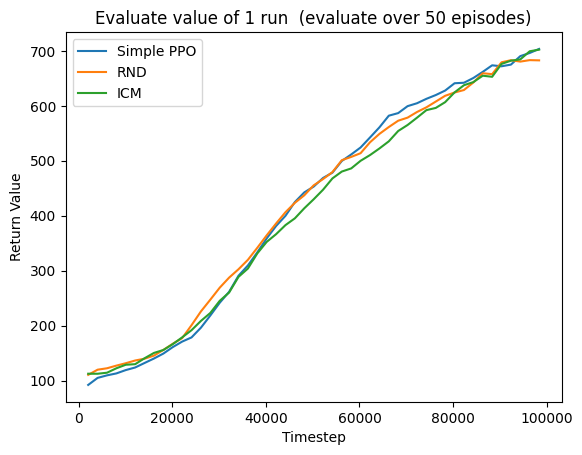

In [9]:
# Plot the data
plt.plot(df_simple_PPO["global_step"], df_simple_PPO["return_value_smoothed"], label='Simple PPO')
plt.plot(df_rnd["global_step"], df_rnd["return_value_smoothed"], label='RND')
plt.plot(df_icm["global_step"], df_icm["return_value_smoothed"], label='ICM')
plt.xlabel('Timestep')
plt.ylabel('Return Value')
plt.title('Evaluate value of 1 run  (evaluate over 50 episodes)')
plt.legend()
plt.show()

- When experimenting with the CartPole environment, we didn't observe significant differences between using simple PPO and incorporating exploration methods.
- We attribute this to the environment's simplicity, which renders exploration techniques unnecessary.
- However, if you explore the notebook "Memory_for_Surprise-driven_Exploration_Atari.ipynb", you will find the considerably more challenging environment where exploration techniques demonstrate significant impact.